In [1]:
!module load cuda 
!module list

1h=
Currently Loaded Modules:
  1) modules/2.3-20240529 (S)   2) slurm   3) openblas/single-0.3.26 (S)

  Where:
   S:  Module is Sticky, requires --force to unload or purge

 

>

In [2]:
#import tensorflow as tf; print(tf.config.list_physical_devices('GPU')) 
from _utils import *
from _polychrom import *
import openmm.testInstallation
openmm.testInstallation.main()

'''
 Polymer simulations
 This version implements simulations of Cohesin-mediated loop extrusion and heterotypic chromatin interactions.
 This script reads in 15 variable parameters from a text file.  The parameter text file is typically produced programatically, since parameters that specify all the CTCF sites, for example, are quite long arrays. 
'''

import sys

import os
import pickle 
import numpy as np
import numpy.matlib
import h5py
import ast
import pandas as pd
import math

from LEBondUpdater import bondUpdater

import polychrom
from polychrom.starting_conformations import grow_cubic
from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file
from polychrom.simulation import Simulation
from polychrom import polymerutils
from polychrom import forces
from polychrom import forcekits
import time

from tqdm.auto import tqdm


2024-11-04 18:33:43.107577: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 18:33:43.152314: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.



OpenMM Version: 8.1.1
Git Revision: Unknown

There are 3 Platforms available:

1 Reference - Successfully computed forces
2 CPU - Successfully computed forces
3 OpenCL - Successfully computed forces

Median difference in forces between platforms:

Reference vs. CPU: 6.29227e-06


KeyboardInterrupt: 

In [2]:
monomers = 5000  # change this to multiple of ctcf sites 
replicates = 1
lef_lifetime = 20  # 40 gives better result than 10
lef_separation = 10
ctcf_sites = None 
ctcf_capture = 1
ctcf_release = 0.003
ctcf_dir = None 
monomer_types = None 
interaction_matrix = None 
trajectory_length = 1000 * 10  # More samples show better results 
density = 0.2
load_prob = 1/monomers 
gpu_id = "0"
repulsion = 6
lef_flag = True 

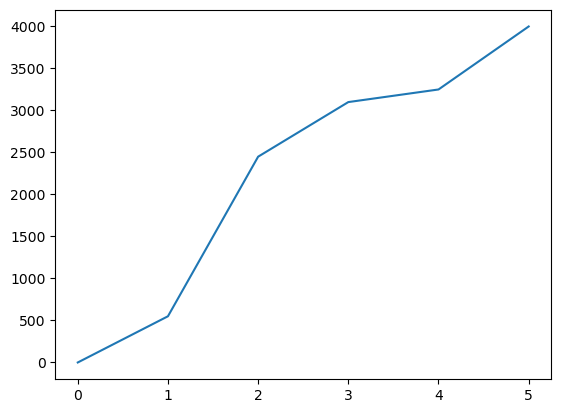

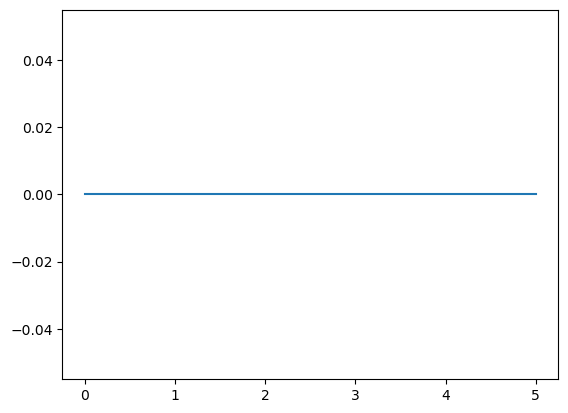

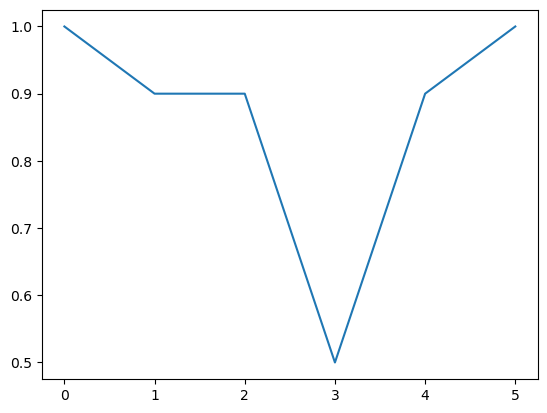

In [3]:
ctcf_sites_one_iter = np.array([0, 11, 49, 62, 65, 80]) * 50
ctcf_capture_one_iter = np.array([1, 0.9, 0.9, 0.5, 0.9, 1])
ctcf_dir_one_iter = np.array([0, 0, 0, 0, 0, 0])

monomers = int(ctcf_sites_one_iter.max())*1

ctcf_sites = np.append(np.zeros([0]), ctcf_sites_one_iter)
ctcf_capture = np.append(np.zeros([0]), ctcf_capture_one_iter)
ctcf_dir = np.append(np.zeros([0]), ctcf_dir_one_iter)

while np.max(ctcf_sites) < monomers:
    print('Max CTCF sites:', np.max(ctcf_sites))
    ctcf_sites_next = np.max(ctcf_sites) + ctcf_sites_one_iter 
    
    ctcf_sites = np.append(ctcf_sites, ctcf_sites_next[1:])
    ctcf_capture = np.append(ctcf_capture, ctcf_capture_one_iter[1:])
    ctcf_dir = np.append(ctcf_dir, ctcf_dir_one_iter[1:])
    
    print(len(ctcf_sites), len(ctcf_dir), len(ctcf_capture))
    
ctcf_sites = ctcf_sites.astype(int)[:monomers]
ctcf_capture = ctcf_capture[:monomers]
ctcf_dir = ctcf_dir[:monomers]

plt.plot(ctcf_sites)
plt.show()
plt.plot(ctcf_dir)
plt.show()

plt.plot(ctcf_capture)

In [4]:
lef_lifetime = 250
lef_separation = 100
ctcf_release = np.ones_like(ctcf_sites) * ctcf_release
load_prob = np.ones(monomers) * load_prob

monomer_types = np.zeros(monomers, dtype=int)
interaction_matrix = np.array([[0, 0], [0, 0]])

In [5]:
save_folder = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241104_Sox9_EmpiricalCTCF_Interactive_Trajectory'

In [6]:
# Change here
params = {
    'monomers': monomers,
    'replicates': replicates,
    'lef_lifetime': lef_lifetime,
    'lef_separation': lef_separation,
    'ctcf_capture': ctcf_capture,
    'ctcf_release': ctcf_release,
    'save_folder': save_folder,
    'ctcf_dir': ctcf_dir,
    'ctcf_sites': ctcf_sites,
    'monomer_types': monomer_types,
    'interaction_matrix': interaction_matrix,
    'trajectory_length': trajectory_length,
    'density': density,
    'load_prob': load_prob,
    'gpu_id': gpu_id,
    'repulsion': repulsion,
    'lef_flag': True
}

In [7]:
# general parameters 
trajectoryLength = params['trajectory_length'] # time duration of simulation 
density = params['density'] #  0.2  # fraction of the volume of the sphere which is occupied by the polymer (or effective excluded volume, if using periodic boundary conditions)
  
   
#  ==========Extrusion sim parameters====================
# there is probably a more elegant way to read in text values than ast.literal_eval, but this works.  
GPU_ID = params['gpu_id'] # this should be a string -- which GPU to run on, eg "0", or "1" 
repulsionEnergy = params['repulsion'] # this is just a number
N1 = params['monomers'] # Number of monomers in the polymer/chromosome
M = params['replicates']  # Number of chromosomes in the simulation
num_chains = M  # same as above, multiple variable names were introduced.
N = N1 * M # total number of monomers in the full simulation 
LIFETIME = params['lef_lifetime'] #  extruder lifetime
SEPARATION = params['lef_separation'] # separation between extruders in monomer units (extruder density) 
ctcfSites = params['ctcf_sites'] # CTCF site locations, in monomer units
ctcfDir = params['ctcf_dir']  # CTCF site direction 
ctcfCapture = params['ctcf_capture'] # 0.9 80% capture probability per block, if capture < than this, capture  
ctcfRelease = params['ctcf_release'] # 0.003 % release probability per block, if capture < than this, release
interactionMatrix = params['interaction_matrix']  # interaction strength between different compartments 
saveFolder = params['save_folder']  # place to save the data
oneChainMonomerTypes =  params['monomer_types'] # compartment labels
lefFlag = params['lef_flag']
if len(oneChainMonomerTypes) != N1:
    oneChainMonomerTypes = np.zeros(N1).astype(int)
    
# Allow biased cohesin loading probabilities (e.g. as a function of chromatin state), if desired
loadProb = params['load_prob'] # discrete probability distribution that cohesin loads at site N
loadProb = numpy.matlib.repmat(loadProb,1,M)
loadProb = loadProb/np.sum(loadProb) 

if not os.path.exists(saveFolder):
    os.mkdir(saveFolder)

lefPosFile = saveFolder + "LEFPos.h5"
if lefFlag:
    LEFNum = max(0,math.floor(N // SEPARATION )-1)
else:
    LEFNum = 0

# Optionally, tether the chromosome ends at random positions on the nulcear lamina
#   to use this, line 245 should be replaced with the commented line below it. 
#   select M random points on the edge of sphere
r = 1.05*(3 * N/ (4 * np.pi * density)) ** (1 / 3.0)
theta =np.random.rand(num_chains,1)*np.pi
psi = np.random.rand(num_chains,1)*2*np.pi
x= r*np.cos(psi)*np.sin(theta)
y= r*np.sin(psi)*np.sin(theta)
z= r*np.cos(theta)
end_tethers = np.concatenate((x,y,z),axis=1).tolist() 


# less common parameters
attraction_radius = 1.5
MDstepsPerCohesinStep = 800
smcBondWiggleDist = 0.2
smcBondDist = 0.5
saveEveryBlocks = 100   #
restartSimulationEveryBlocks = 100

# check that these loaded alright
print(f'LEF count: {LEFNum}')
print('interaction matrix:')
print(interactionMatrix)
print('monomer types:')
print(oneChainMonomerTypes)
print(saveFolder)
print('Starting simulation')


LEF count: 39
interaction matrix:
[[0 0]
 [0 0]]
monomer types:
[0 0 0 ... 0 0 0]
/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241104_Sox9_EmpiricalCTCF_Interactive_Trajectory
Starting simulation


In [8]:


#==================================#
# Run 
#=================================#

#=========== 1D LE Simulation first ============#
import extrusion1Dv2 as ex1D # 1D classes 
ctcfLeftRelease = {}
ctcfRightRelease = {}
ctcfLeftCapture = {}
ctcfRightCapture = {}

# should modify this to allow directionality
for i in range(M): # loop over chains (this variable needs a better name Max)
    for t in range(len(ctcfSites)):
        pos = i * N1 + ctcfSites[t] 
        if ctcfDir[t] == 0:
            ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
            ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
            ctcfRightCapture[pos] = ctcfCapture[t]
            ctcfRightRelease[pos] = ctcfRelease[t]
        elif ctcfDir[t] == 1: # stop Cohesin moving toward the right  
            ctcfLeftCapture[pos] = 0  
            ctcfLeftRelease[pos] = 1  
            ctcfRightCapture[pos] = ctcfCapture[t]
            ctcfRightRelease[pos] = ctcfRelease[t]
        elif ctcfDir[t] == 2:
            ctcfLeftCapture[pos] = ctcfCapture[t]  # if random [0,1] is less than this, capture
            ctcfLeftRelease[pos] = ctcfRelease[t]  # if random [0,1] is less than this, release
            ctcfRightCapture[pos] = 0
            ctcfRightRelease[pos] = 1
       
args = {}
args["ctcfRelease"] = {-1:ctcfLeftRelease, 1:ctcfRightRelease}
args["ctcfCapture"] = {-1:ctcfLeftCapture, 1:ctcfRightCapture}        
args["N"] = N 
args["LIFETIME"] = LIFETIME
args["LIFETIME_STALLED"] = LIFETIME  # no change in lifetime when stalled 

occupied = np.zeros(N)
occupied[0] = 1  # (I think this is just prevent the cohesin loading at the end by making it already occupied)
occupied[-1] = 1 # [-1] is "python" for end
cohesins = []

print('starting simulation with N LEFs=')
print(LEFNum)
for i in tqdm(range(LEFNum)):
    ex1D.loadOneFromDist(cohesins,occupied, args,loadProb) # load the cohesins 
    
# if lefPosFile exists, delete it
if os.path.exists(lefPosFile):
    os.remove(lefPosFile)


with h5py.File(lefPosFile, mode='w') as myfile:
    dset = myfile.create_dataset("positions", 
                                 shape=(trajectoryLength, LEFNum, 2), 
                                 dtype=np.int32, 
                                 compression="gzip")
    steps = 100    # saving in 100 chunks because the whole trajectory may be large 
    bins = np.linspace(0, trajectoryLength, steps, dtype=int) # chunks boundaries 
    print(len(bins))
    for st,end in tqdm(zip(bins[:-1], bins[1:])):
        cur = []
        for i in range(st, end):
            ex1D.translocate(cohesins, occupied, args,loadProb)  # actual step of LEF dynamics 
            positions = [(cohesin.left.pos, cohesin.right.pos) for cohesin in cohesins]
            cur.append(positions)  # appending current positions to an array 
        cur = np.array(cur)  # when we finished a block of positions, save it to HDF5 
        dset[st:end] = cur
    myfile.attrs["N"] = N
    myfile.attrs["LEFNum"] = LEFNum
    


starting simulation with N LEFs=
39


  0%|          | 0/39 [00:00<?, ?it/s]

100


0it [00:00, ?it/s]

In [9]:
#=========== Load LEF simulation ===========#
trajectory_file = h5py.File(lefPosFile, mode='r')
LEFNum = trajectory_file.attrs["LEFNum"]  # number of LEFs
LEFpositions = trajectory_file["positions"]  # array of LEF positions  
steps = MDstepsPerCohesinStep # MD steps per step of cohesin  (set to ~800 in real sims)
Nframes = LEFpositions.shape[0] # length of the saved trajectory (>25000 in real sims)
print(f'Length of the saved trajectory: {Nframes}')
block = 0  # starting block 

# test some properties 
# assertions for easy managing code below 
assert (Nframes % restartSimulationEveryBlocks) == 0 
assert (restartSimulationEveryBlocks % saveEveryBlocks) == 0

savesPerSim = restartSimulationEveryBlocks // saveEveryBlocks
simInitsTotal  = (Nframes) // restartSimulationEveryBlocks
# concatinate monomers if needed
if len(oneChainMonomerTypes) != N:
    monomerTypes = np.tile(oneChainMonomerTypes, num_chains)
else:
    monomerTypes = oneChainMonomerTypes
    
N_chain = len(oneChainMonomerTypes)  
N = len(monomerTypes)
print(f'N_chain: {N_chain}')  # ~8000 in a real sim
print(f'N: {N}')   # ~40000 in a real sim
N_traj = trajectory_file.attrs["N"]
print(f'N_traj: {N_traj}')
assert N == trajectory_file.attrs["N"]
print(f'Nframes: {Nframes}')
print(f'simInitsTotal: {simInitsTotal}')


Length of the saved trajectory: 10000
N_chain: 4000
N: 4000
N_traj: 4000
Nframes: 10000
simInitsTotal: 100


In [10]:

#==============================================================#
#      RUN 3D simulation using 1D LEF constraints              #
#==============================================================#
milker = bondUpdater(LEFpositions)
data = grow_cubic(N,int((N/(density*1.2))**0.333))  # starting conformation
reporter = HDF5Reporter(folder=saveFolder, max_data_length=50, overwrite=True)
chains = [(N_chain*(k),N_chain*(k+1),0) for k in range(num_chains)]
positions_all_iterations = []

for iteration in tqdm(range(simInitsTotal)):
    position_curr_iteration = []
    a = Simulation(N=N, 
                   error_tol=0.01, 
                   collision_rate=0.01, 
                   integrator ="variableLangevin", 
                   GPU = "0",
                   platform="CUDA",
                   PBCbox=False, 
                   reporters=[reporter],
                   precision="mixed")  
    a.set_data(data)  # Start from previous positions
    position_curr_iteration.append(a.get_data())
    a.add_force(
        polychrom.forcekits.polymer_chains(
            a,
            chains=chains,
            nonbonded_force_func=polychrom.forces.heteropolymer_SSW,
            nonbonded_force_kwargs={
                'repulsionEnergy': repulsionEnergy,  # base repulsion energy for all monomers (function default is 3.0)
                'attractionEnergy': 0,  # base attraction energy for all monomers (function default is 3.0)
                'attractionRadius': attraction_radius,
                'interactionMatrix': interactionMatrix,
                'monomerTypes': monomerTypes,
                'extraHardParticlesIdxs': []
            },
            bond_force_kwargs={
                'bondLength': 1,
                'bondWiggleDistance': 0.05
            },
            angle_force_kwargs={
                'k': 0.5 
            }
        )
    )
    a.add_force(polychrom.forces.spherical_confinement(a,density=density))
    # a.add_force(polychrom.forces.tether_particles(a,[0,N-1],positions=end_tethers,k=30))  # tether ends of polymer)
    
    # ------------ initializing milker; adding bonds ---------
    kbond = a.kbondScalingFactor / (smcBondWiggleDist ** 2)
    bondDist = smcBondDist * a.length_scale
    activeParams = {"length":bondDist,"k":kbond}
    inactiveParams = {"length":bondDist, "k":0}
    
    milker.setParams(activeParams, inactiveParams)
    # this step actually puts all bonds in and sets first bonds to be what they should be
    milker.setup(bondForce=a.force_dict['harmonic_bonds'],
                blocks=restartSimulationEveryBlocks)

    if iteration == 0:
        a.local_energy_minimization() 
        position_curr_iteration.append(a.get_data())
    else:
        a._apply_forces()
        position_curr_iteration.append(a.get_data())
    
    for i in range(restartSimulationEveryBlocks):        
        if i % saveEveryBlocks == (saveEveryBlocks - 1):  
            a.do_block(steps=steps)
            position_curr_iteration.append(a.get_data())
        else:
            a.integrator.step(steps)  # do steps without getting the positions from the GPU (faster)
            position_curr_iteration.append(a.get_data())
        if i < restartSimulationEveryBlocks - 1: 
            curBonds, pastBonds = milker.step(a.context)  # this updates bonds.
    
    data = a.get_data()  # save data and step, and delete the simulation
    
    del a
    
    reporter.blocks_only = False  # Write output hdf5-files only for blocks
    
    time.sleep(0.2)  # wait 200ms for sanity (to let garbage collector do its magic)
    positions_all_iterations.append(position_curr_iteration)

reporter.dump_data()

  0%|          | 0/100 [00:00<?, ?it/s]

OpenMMException: There is no registered Platform called "CUDA"